# DDPG with OpenAI gym - PyTorch



## Setup virtual display 

In [3]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.*

## First we initialize a virtual display

#import pyvirtualdisplay

#_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900)) #Use false with xvfb
#_ = _display.start() 

#!echo $DISPLAY

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Ign:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9
Err:3 http://security.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9
  404  Not Found [IP: 91.189.88.152 80]
Fetched 209 kB in 1s (224 kB/s)
E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/universe/x/xorg-server/xvfb_1.19.6-1ubun

## Import Libraries

In [4]:
import gym
import math
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from copy import deepcopy

%matplotlib inline

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Clone repo and set path

In [5]:
%cd /content/
!git clone https://github.com/ARG-NCTU/pytorch-ddpg

/content
Cloning into 'pytorch-ddpg'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 83 (delta 0), reused 1 (delta 0), pack-reused 80
Unpacking objects: 100% (83/83), done.


In [6]:
import os
import sys

sys.path.append('/content/pytorch-ddpg')

from ddpg import DDPG
from model import Actor, Critic
from util import *
from normalized_env import *
from evaluator import *

# test for import packages
actor_net = Actor(300, 2)
critic_net = Critic(300, 2)

print(actor_net)
print(critic_net)

Actor(
  (fc1): Linear(in_features=300, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=2, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)
Critic(
  (fc1): Linear(in_features=300, out_features=400, bias=True)
  (fc2): Linear(in_features=402, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
  (relu): ReLU()
)


## Setup for Gym Environment

The Box space represents an n-dimensional box, so valid observations will be an array of the numbers of state/action. 

We can also check the Box’s bounds (high and low).

In [7]:
env = gym.make('Pendulum-v0')
#env = NormalizedEnv(gym.make('Pendulum-v0'))

print(env.observation_space)
print(env.action_space)

nb_states = env.observation_space.shape[0]
nb_actions = env.action_space.shape[0]

print(nb_states)
print(env.observation_space.high)
print(env.observation_space.low)

print(nb_actions)
print(env.action_space.high)
print(env.action_space.low)

Box(-8.0, 8.0, (3,), float32)
Box(-2.0, 2.0, (1,), float32)
3
[1. 1. 8.]
[-1. -1. -8.]
1
[2.]
[-2.]


## Training

Here we move the code in main.py to Colab

### Prepare for Require parameters and DDPG Agent

In [8]:
class Args:
  mode = 'train'
  hidden1 = 400
  hidden2 = 300
  rate = 0.001   # learning rate
  prate = 0.0001 # policy net learning rate (only for DDPG)
  warmup = 100  # time without training but only filling the replay memory
  discount = 0.99
  bsize = 64     # minibatch size
  rmsize = 6000000 # memory size
  window_length = 1
  tau = 0.001      # moving average for target network
  ou_theta = 0.15  # noise theta
  ou_sigma = 0.2   # noise sigma
  ou_mu    = 0.0   # noise mu
  validate_episodes = 20
  max_episode_length = 500
  validate_steps = 2000
  output = 'output' # store trained model and stuffs
  resume = 'output' # Resuming model path for testing
  debug = 'debug'
  init_w = 0.003
  train_iter = 40000 # default: 200000
  epsilon = 50000 # linear decay of exploration policy
  seed = -1


args = Args()

agent = DDPG(nb_states, nb_actions, args)
evaluate = Evaluator(args.validate_episodes, 
                     args.validate_steps, 
                     args.output, 
                     max_episode_length=args.max_episode_length)


### Training

In [9]:
def train(num_iterations, agent, env,  evaluate, validate_steps, output, max_episode_length=None, debug=False):

    agent.is_training = True
    step = episode = episode_steps = 0
    episode_reward = 0.
    observation = None
    while step < num_iterations:
        # reset if it is the start of episode
        if observation is None:
            observation = deepcopy(env.reset())
            agent.reset(observation)

        # agent pick action ...
        if step <= args.warmup:
            action = agent.random_action()
        else:
            action = agent.select_action(observation)
        
        # env response with next_observation, reward, terminate_info
        observation2, reward, done, info = env.step(action)
        observation2 = deepcopy(observation2)
        if max_episode_length and episode_steps >= max_episode_length -1:
            done = True

        # agent observe and update policy
        agent.observe(reward, observation2, done)
        if step > args.warmup :
            agent.update_policy()
        
        # [optional] evaluate
        if evaluate is not None and validate_steps > 0 and step % validate_steps == 0:
            policy = lambda x: agent.select_action(x, decay_epsilon=False)
            validate_reward = evaluate(env, policy, debug=False, visualize=False)
            if debug: prCyan('[Evaluate] Step_{:07d}: mean_reward:{}'.format(step, validate_reward))

        # [optional] save intermideate model
        if step % int(num_iterations/3) == 0:
            agent.save_model(output)

        # update 
        step += 1
        episode_steps += 1
        episode_reward += reward
        observation = deepcopy(observation2)

        if done: # end of episode
            if debug: prGreen('#{}: episode_reward:{} steps:{}'.format(episode,episode_reward,step))

            agent.memory.append(
                observation,
                agent.select_action(observation),
                0., False
            )

            # reset
            observation = None
            episode_steps = 0
            episode_reward = 0.
            episode += 1


/content/pytorch-ddpg
 [Evaluate] Step_0000000: mean_reward:-1318.0536708016216
 #0: episode_reward:-2.297982756582826 steps:2


/content/pytorch-ddpg/util.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  torch.from_numpy(ndarray), volatile=volatile, requires_grad=requires_grad
/content/pytorch-ddpg/ddpg.py:72: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_q_values.volatile=False


 #1: episode_reward:-1071.4031429615814 steps:202
 #2: episode_reward:-1554.232706325288 steps:402
 #3: episode_reward:-1724.9822501670865 steps:602
 #4: episode_reward:-1332.0029453034626 steps:802
 #5: episode_reward:-1208.0099816534043 steps:1002
 #6: episode_reward:-1573.364482320426 steps:1202
 #7: episode_reward:-1366.640960500109 steps:1402
 #8: episode_reward:-1746.9268036325607 steps:1602
 #9: episode_reward:-1661.2615037852788 steps:1802
 [Evaluate] Step_0002000: mean_reward:-1282.1877083859795
 #10: episode_reward:-1242.897402333468 steps:2002
 #11: episode_reward:-1739.1673241814765 steps:2202
 #12: episode_reward:-1182.7367976401833 steps:2402
 #13: episode_reward:-1718.838420262078 steps:2602
 #14: episode_reward:-1328.8642505468056 steps:2802
 #15: episode_reward:-1550.4763119246854 steps:3002
 #16: episode_reward:-1495.7233190106729 steps:3202
 #17: episode_reward:-1586.7872804759556 steps:3402
 #18: episode_reward:-1681.918256571245 steps:3602
 #19: episode_reward:-170

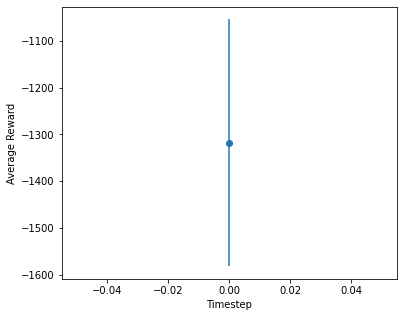

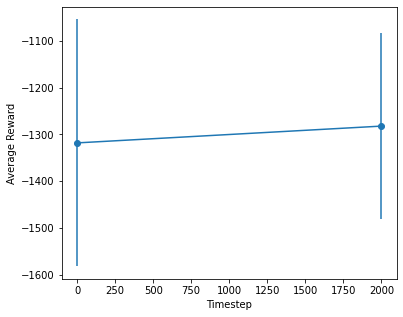

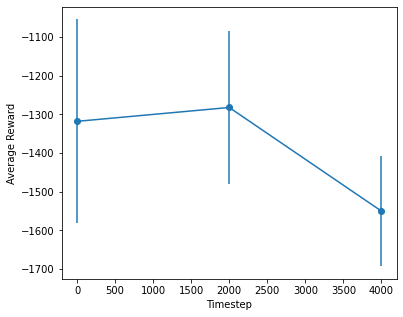

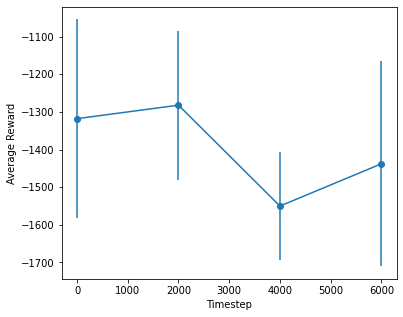

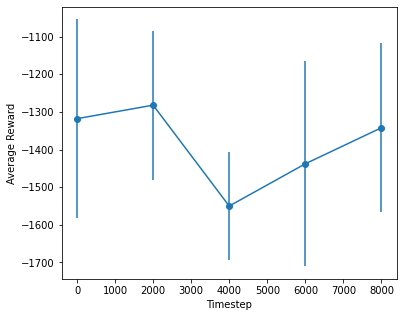

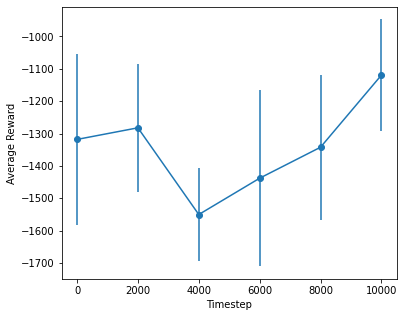

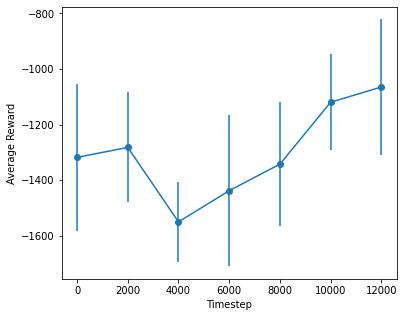

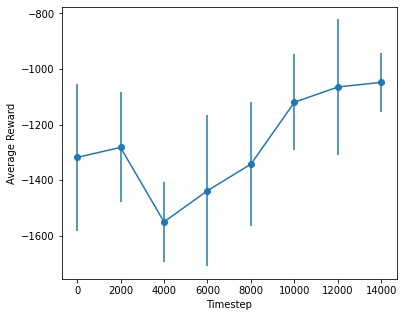

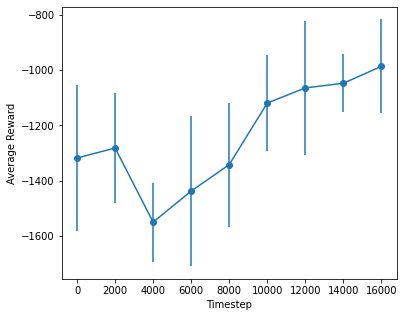

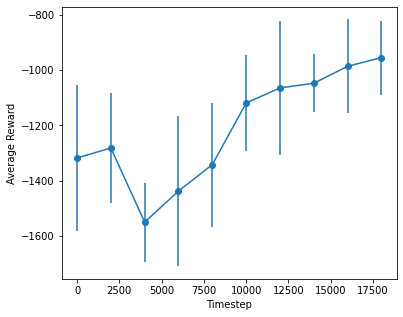

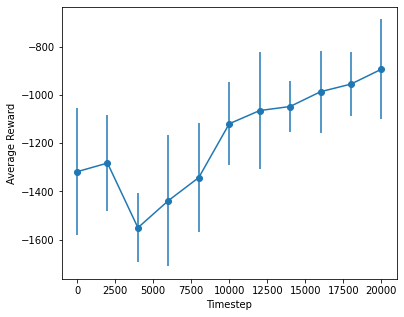

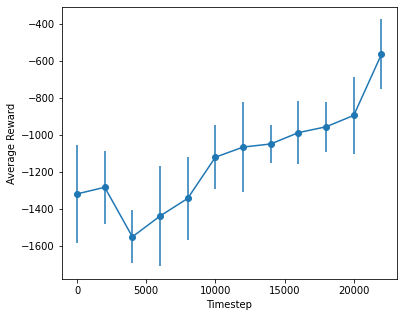

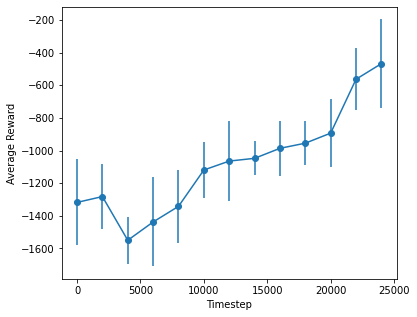

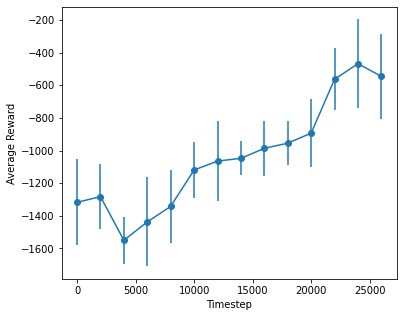

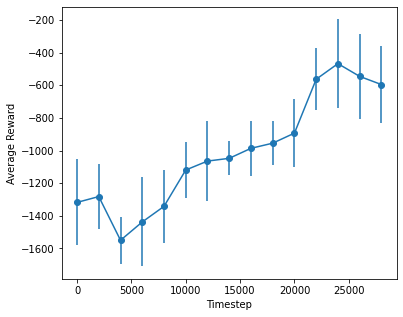

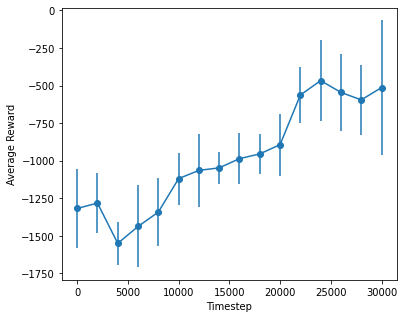

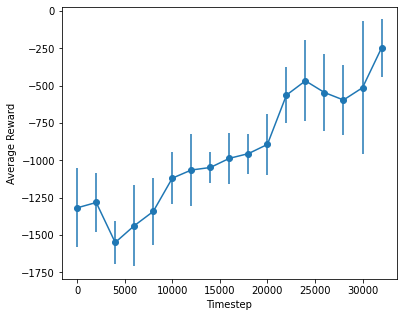

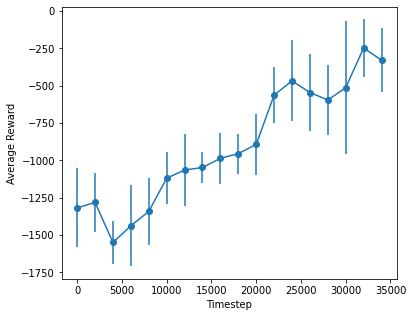

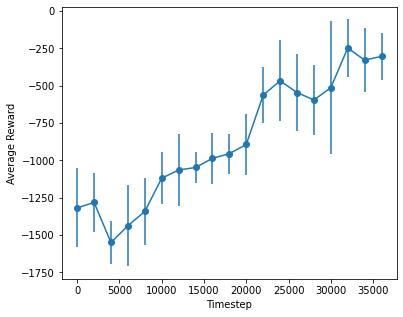

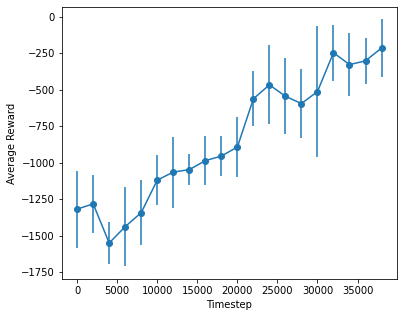

In [10]:
%cd /content/pytorch-ddpg/
train(args.train_iter, agent, env, evaluate, 
      args.validate_steps, args.output, 
      max_episode_length=args.max_episode_length, 
      debug=args.debug)

## Testing

In [11]:
def test(num_episodes, agent, env, evaluate, model_path, visualize=True, debug=False):

    agent.load_weights(model_path)
    agent.is_training = False
    agent.eval()
    policy = lambda x: agent.select_action(x, decay_epsilon=False)

    for i in range(num_episodes):
        validate_reward = evaluate(env, policy, debug=debug, visualize=visualize, save=False)
        if debug: prPurple('[Evaluate] #{}: mean_reward:{}'.format(i, validate_reward))


In [12]:
test(args.validate_episodes, agent, env, evaluate, 
     args.resume, visualize=False, debug=args.debug)

 [Evaluate] #Episode0: episode_reward:-367.1646589592724
 [Evaluate] #Episode1: episode_reward:-248.96391097473298
 [Evaluate] #Episode2: episode_reward:-244.70925578432082
 [Evaluate] #Episode3: episode_reward:-239.67683556245774
 [Evaluate] #Episode4: episode_reward:-122.97300160163707
 [Evaluate] #Episode5: episode_reward:-124.67548922671945
 [Evaluate] #Episode6: episode_reward:-592.2186609433616
 [Evaluate] #Episode7: episode_reward:-356.6290272905167
 [Evaluate] #Episode8: episode_reward:-121.76230206979827
 [Evaluate] #Episode9: episode_reward:-121.93277804502249
 [Evaluate] #Episode10: episode_reward:-600.3590637351009
 [Evaluate] #Episode11: episode_reward:-124.87828288328811
 [Evaluate] #Episode12: episode_reward:-122.75032597405728
 [Evaluate] #Episode13: episode_reward:-240.39637032060537
 [Evaluate] #Episode14: episode_reward:-243.37303613620236
 [Evaluate] #Episode15: episode_reward:-0.4019996923966869
 [Evaluate] #Episode16: episode_reward:-367.3456769163549
 [Evaluate] 